# Identifying Duplicate Questions

Welcome to the Quora Question Pairs competition! Here, our goal is to identify which questions asked on [Quora](https://www.quora.com/), a quasi-forum website with over 100 million visitors a month, are duplicates of questions that have already been asked. This could be useful, for example, to instantly provide answers to questions that have already been answered. We are tasked with predicting whether a pair of questions are duplicates or not, and submitting a binary prediction against the logloss metric.

If you have any questions or want to discuss competitions/hardware/games/anything with other Kagglers, then join the KaggleNoobs Slack channel [here](https://goo.gl/gGWFXe). We also have regular AMAs with top Kagglers there.

**And as always, if this helped you, some upvotes would be very much appreciated - that's where I get my motivation! :D**

Let's dive right into the data!

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
.DS_Store                     0.01MB
test.csv                      314.02MB
train.csv                     63.4MB


Looks like we are simply given two files this time round, one for the training set and one for the test set. They are relatively small compared to other recent competitions, weighing in at less than 400MB total.

It's worth noting that there is a lot more testing data than training data. This could be a sign that some of the test data is dummy data designed to deter hand-labelling, and not included in the calculations, like we recently saw in the [DSTL competition](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/leaderboard).

Let's open up one of the datasets.

## Training set

In [7]:
df_train = pd.read_csv('../input/train.csv')
pd.options.display.max_colwidth = 100
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [3]:
df_train.loc[df_train['is_duplicate']==1].head(40)

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
15,15,31,32,What would a Trump presidency mean for current international master’s students on an F1 visa?,How will a Trump presidency affect the students presently in US or planning to study in US?,1
16,16,33,34,What does manipulation mean?,What does manipulation means?,1
18,18,37,38,Why are so many Quora users posting questions that are readily answered on Google?,Why do people ask Quora questions which can be answered easily by Google?,1
20,20,41,42,Why do rockets look white?,Why are rockets and boosters painted white?,1
29,29,59,60,How should I prepare for CA final law?,How one should know that he/she completely prepare for CA final exam?,1


We are given a minimal number of data fields here, consisting of:

**`id`:** Looks like a simple rowID    
**`qid{1, 2}`:** The unique ID of each question in the pair    
**`question{1, 2}`:** The actual textual contents of the questions.    
**`is_duplicate`:** The **label** that we are trying to predict - whether the two questions are duplicates of each other.

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



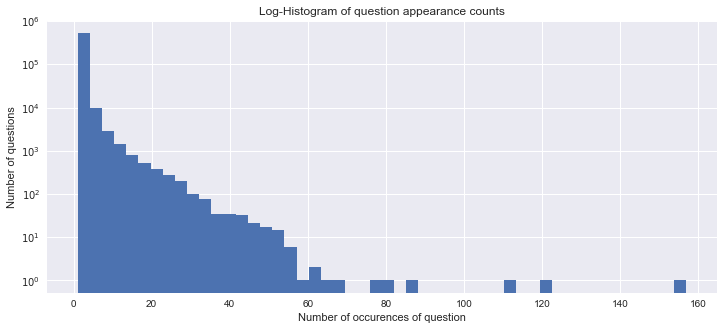

In [4]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

# Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

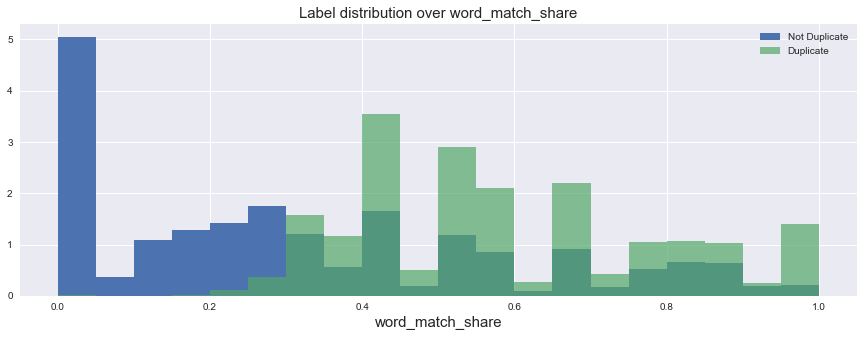

In [9]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

# Synonims

In [18]:
from nltk.corpus import wordnet as wn
    
def get_synonims(word):
    result = set()
    for synset in wn.synsets(word):
        result.update(synset.lemma_names())
    return result

def get_all_synonims(words):
    result = set()
    for word in words:
        result.update(get_synonims(word))
    return result

print(get_synonims('banana'))
print(get_all_synonims(['banana', 'faggot']))

words = [w for w in 'What was your first sexual experience like'.lower().split() if w not in stops]
print(words)
print(get_all_synonims(words))


{'banana', 'banana_tree'}
{'pouf', 'banana', 'fag', 'queer', 'fagot', 'faggot', 'fairy', 'queen', 'poof', 'pansy', 'poove', 'nance', 'faggot_up', 'banana_tree'}
['first', 'sexual', 'experience', 'like']
{'number_one', 'ilk', 'first_gear', 'comparable', 'commencement', 'go_through', 'alike', 'low_gear', 'low', 'initiative', 'get-go', 'the_likes_of', 'intimate', 'know', 'outset', 'get', 'first-class_honours_degree', 'showtime', 'same', 'foremost', 'first_off', '1st', 'live', 'have', 'sexual', 'receive', 'world-class', 'kickoff', 'number_1', 'see', 'feel', 'similar', 'firstly', 'first_of_all', 'inaugural', 'wish', 'care', 'first_base', 'beginning', 'experience', 'starting_time', 'maiden', 'initiatory', 'like', 'the_like', 'corresponding', 'start', 'offset', 'first', 'for_the_first_time'}


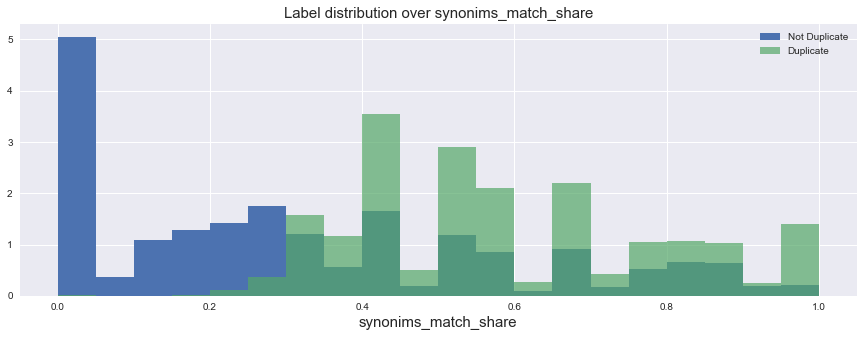

In [10]:
def synonims_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    q1words_synonims = get_all_synonims(q1words)
    q2words_synonims = get_all_synonims(q2words)
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words_synonims]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words_synonims]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
synonims_word_match = df_train.apply(synonims_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over synonims_match_share', fontsize=15)
plt.xlabel('synonims_match_share', fontsize=15)

Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

## TF-IDF

I'm now going to try to improve this feature, by using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how **uncommon** they are, meaning that we care more about rare words existing in both questions than common one. This makes sense, as for example we care more about whether the word "exercise" appears in both than the word "and" - as uncommon words will be more indicative of the content.

You may want to look into using sklearn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute weights if you are implementing this yourself, but as I am too lazy to read the documentation I will write a version in pure python with a few changes which I believe should help the score.

In [11]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

NameError: name 'train_qs' is not defined

In [39]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [12]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


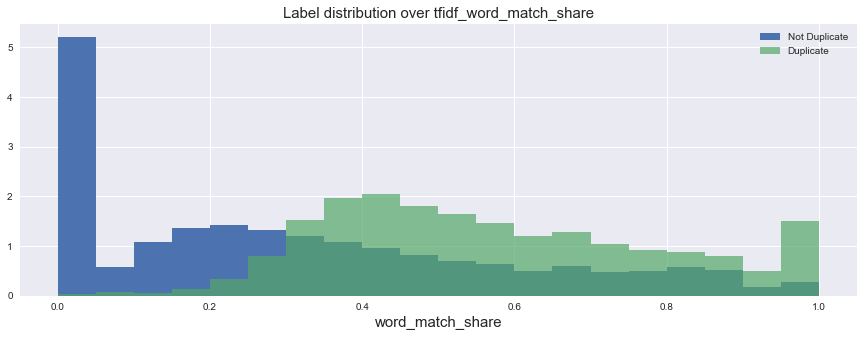

In [41]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [14]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('Synonyms AUC:', roc_auc_score(df_train['is_duplicate'], synonims_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.780553200628
Synonyms AUC: 0.697036460638


NameError: name 'tfidf_train_word_match' is not defined

So it looks like our TF-IDF actually got _worse_ in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

However, I still think that this feature should provide some extra information which is not provided by the original feature. Our next job is to combine these features and use it to make a prediction. For this, I will use our old friend XGBoost to make a classification model.

## Rebalancing the Data
However, before I do this, I would like to rebalance the data that XGBoost receives, since we have 37% positive class in our training data, and only 17% in the test data. By re-balancing the data so our training set has 17% positives, we can ensure that XGBoost outputs probabilities that will better match the data on the leaderboard, and should get a better score (since LogLoss looks at the probabilities themselves and not just the order of the predictions like AUC)

In [20]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [21]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [22]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

//anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## XGBoost

Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [23]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

**0.35460** on the leaderboard - a good first score!